# Data description & Problem statement: 
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The type of dataset and problem is a classic supervised binary classification. Given a number of elements all with certain characteristics (features), we want to build a machine learning model to identify people affected by type 2 diabetes.

# Workflow:
- Load the dataset
- Basic data processing

## 1) Local mode training, by using a subset of large dataset

## 2) Training on SageMaker Cloud:
   - Prepare data for SageMaker cloud training:
       - Convert data to .csv and .recordio types
       - Upload training and validation datasets to S3 bucket
       
   - Specify training algorithm Docker Image
   - Build the XGBoost model
   - Specify training data location and optionally, validation data location
   - Train the model on SageMaker cloud
   - Deploy the model, and run real-time predictions
   - Evaluate the initial model (by R^2, Lift chart, RMSE, Box-plot for prediction Vs. actual values, Distribution plot of residuals)

## 3) Hyper-parameters tuning on SageMaker Cloud: Model Optimization
   - Specify range/value of hyperparameters, and launch tuning
   - Track hyper-parameter tuning job process
   - Analyze the correlation between objective metric and individual parameters
   - Deploy the best model, and run real-time predictions
   - Evaluate the best model (by auc score, confusion matrix, f1 score, roc curve, etc.) 




In [1]:
# Istall XGBoost package and update numpy (for the local mode):
!conda install -y -c conda-forge xgboost
!conda update -y numpy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |           py36_1         139 KB  conda-forge

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0      --> 2018.8.24-ha4d7672_0 conda-forge
    certifi:         2018.8.24-py36_1  --> 2018.8.24-py36_1     conda-forge
    openssl:         1.0.2p-h14c3975_0 --> 1.0.2p-h470a237_0    conda-forge


certifi 2018.8.24: ##################################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environmen

In [2]:
import sklearn
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [3]:
df=pd.read_csv('indiansDiabetes_All.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Number of times pregnant                                                    768 non-null int64
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    768 non-null int64
Diastolic blood pressure (mm Hg)                                            768 non-null int64
Triceps skin fold thickness (mm)                                            768 non-null int64
2-Hour serum insulin (mu U/ml)                                              768 non-null int64
Body mass index                                                             768 non-null float64
Diabetes pedigree function                                                  768 non-null float64
age                                                                         768 non-null int64
target                                                                      768 non-null int64
dtypes: float64(2), int64(7)
memory u

# Data Preparation/Cleaning:

In [4]:
df.columns=['NP', 'GC', 'BP', 'ST', 'I',  'BMI', 'PF', 'Age', 'Class']

df['ST'].replace(0, df[df['ST']!=0]['ST'].mean(), inplace=True)
df['GC'].replace(0, df[df['GC']!=0]['GC'].mean(), inplace=True)
df['BP'].replace(0, df[df['BP']!=0]['BP'].mean(), inplace=True)
df['BMI'].replace(0, df[df['BMI']!=0]['BMI'].mean(), inplace=True)
df['I'].replace(0, df[df['I']!=0]['I'].mean(), inplace=True)

df.head()

,NP,GC,BP,ST,I,BMI,PF,Age,Class
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


In [5]:
X=df.drop('Class', axis=1)
y=df['Class']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)

In [6]:
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1) 

In [7]:
# Write to SageMaker Notebook Instance: It is saved in the folder where this ipynb was created

df_train.to_csv('indiansDiabetes_train.csv', index=False, header=False)
df_test.to_csv('indiansDiabetes_test.csv', index=False, header=False)

#  1) Local Mode Training (usually on a subset of large dataset): 

In [8]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=XGBClassifier() 
kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.75172414 0.77083333 0.76388889 0.79020979] 

Accuracy: 0.77 (+/- 0.01)


# 2)  Training on SageMaker Cloud

# preparing data for SageMaker cloud training: 
    - Converting data to .csv or .recodio types
    - Uploading training & validation datasets to S3 bucket

In [9]:
# Specify the Keys and Location of Train & Test datasets in S3:
bucket_name = 'roohi-ml-sagemaker'
training_file_key = 'indiansDiabetes/diabetes_train.csv'
test_file_key = 'indiansDiabetes/diabetes_test.csv'

s3_model_output_location = r's3://{0}/indiansDiabetes/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,training_file_key)
s3_test_file_location = r's3://{0}/{1}'.format(bucket_name,test_file_key)

In [10]:
# Write and Reading from S3 is just as easy
# files are referred as objects in S3. File name is referred as key name in S3.
# Files stored in S3 are automatically replicated across 3 different availability zones in the region where the bucket was created.
# http://boto3.readthedocs.io/en/latest/guide/s3.html

def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [11]:
write_to_s3('indiansDiabetes_train.csv', bucket_name, training_file_key)
write_to_s3('indiansDiabetes_test.csv', bucket_name, test_file_key)

   # Training Algorithm Docker Image:  
    Note: AWS Maintains a separate image for every region and algorithm

In [12]:
# Registry Path for algorithms provided by SageMaker
#  https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

In [13]:
role = get_execution_role()

# This role contains the permissions needed to train, deploy models
# SageMaker Service is trusted to assume this role
print(role)

arn:aws:iam::928921801380:role/service-role/AmazonSageMaker-ExecutionRole-20180831T120207


# Build model: 

In [14]:
sess = sagemaker.Session()

In [15]:
# Access appropriate algorithm container image
#  Specify how many instances to use for distributed training and what type of machine to use
#  Finally, specify where the trained model artifacts needs to be stored
#   Reference: http://sagemaker.readthedocs.io/en/latest/estimators.html
#    Optionally, give a name to the training job using base_job_name

estimator = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role,
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=s3_model_output_location,
                                       sagemaker_session=sess,
                                       base_job_name ='xgboost-indiansDiabetes-Train')

In [16]:
# Specify hyper parameters that appropriate for the training algorithm
# Take a look this table for metrics & parameters:   https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html

classRatio=df_train['Class'].value_counts()[0]/df_train['Class'].value_counts()[1]

param={'eval_metric':'auc', 
       'objective':'binary:logistic',
       'scale_pos_weight': classRatio,
       'min_child_weight': 2, 
       'subsample': 0.7,
       'num_round':100}
estimator.set_hyperparameters(**param)

estimator.hyperparameters()

{'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'scale_pos_weight': 1.8656716417910448,
 'min_child_weight': 2,
 'subsample': 0.7,
 'num_round': 100}

#    Specify Training Data Location and Optionally, Validation Data Location:

In [18]:
# content type can be libsvm or csv for XGBoost
training_input_config = sagemaker.session.s3_input(s3_data=s3_training_file_location, content_type="csv")
test_input_config = sagemaker.session.s3_input(s3_data=s3_test_file_location, content_type="csv")

print(training_input_config.config)
print(test_input_config.config)

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/indiansDiabetes/diabetes_train.csv'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/indiansDiabetes/diabetes_test.csv'}}, 'ContentType': 'csv'}


# Train the model on SM cloud:

In [19]:
# XGBoost supports "train", "validation" channels
# Reference: Supported channels by algorithm    
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

estimator.fit({'train': training_input_config, 'validation': test_input_config})

INFO:sagemaker:Creating training-job with name: xgboost-indiansDiabetes-Train-2018-09-02-18-04-37-097


.....................

Arguments: train
[2018-09-02:18:07:51:INFO] Running standalone xgboost training.
[2018-09-02:18:07:51:INFO] File size need to be processed in the node: 0.04mb. Available memory size in the node: 8594.73mb
[2018-09-02:18:07:51:INFO] Determined delimiter of CSV input is ','
[18:07:51] S3DistributionType set as FullyReplicated
[18:07:51] 576x8 matrix with 4608 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-02:18:07:51:INFO] Determined delimiter of CSV input is ','
[18:07:51] S3DistributionType set as FullyReplicated
[18:07:51] 192x8 matrix with 1536 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[18:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[0]#011train-auc:0.882726#011validation-auc:0.774687
[18:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[1]#011train-a

Billable seconds: 87


## Deploy Model & Run Predictions:

In [20]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = 'xgboost-indiansDiabetes-Train')

INFO:sagemaker:Creating model with name: xgboost-2018-09-02-18-08-19-270
INFO:sagemaker:Creating endpoint with name xgboost-indiansDiabetes-Train


--------------------------------------------------------------!

In [21]:
# Run Predictions
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [22]:
df_test = pd.read_csv('indiansDiabetes_test.csv', header=None)

X_test=df_test.loc[0:, 1:].as_matrix()
y_test=df_test.loc[0:, 0].as_matrix()

In [23]:
# For large number of predictions, we can split the input data and Query the prediction service.
# array_split is convenient to specify how many splits are needed
probability = []
for arr in np.array_split(X_test,10):
    result = predictor.predict(arr)
    result = result.decode("utf-8")
    result = result.split(',')
    print (arr.shape)
    probability += [float(r) for r in result]
    
predictions=[0 if p<0.5 else 1 for p in probability]

(20, 8)
(20, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)


# Evaluate the initial model:

In [24]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

report=classification_report(y_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       0.80      0.79      0.80       125
          1       0.62      0.63      0.62        67

avg / total       0.74      0.73      0.73       192



Confusion matrix, without normalization
[[99 26]
 [25 42]]
Normalized confusion matrix
[[0.79 0.21]
 [0.37 0.63]]


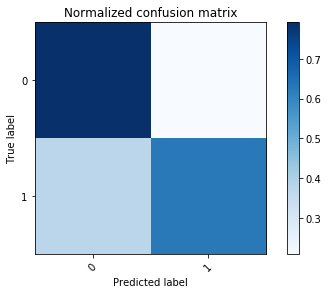

In [25]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["0", "1"]

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

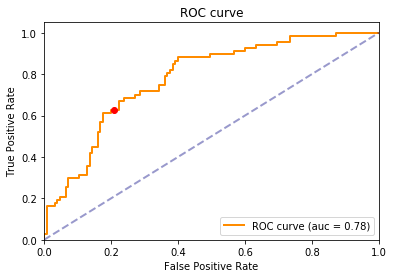

In [26]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test), probability, pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), probability)

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

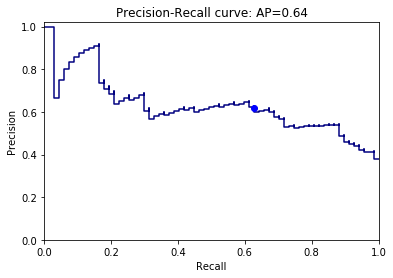

In [28]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test, probability,  pos_label=1)
ave_precision=average_precision_score(y_test, probability)

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot(cm_normalized[1,1], cm[1,1]/(cm[1,1]+cm[0,1]), 'ob')
plt.show()

# 3) Hyperparameters tuning on SM cloud:   Model optimization

In [29]:
#from sagemaker.amazon.amazon_estimator import get_image_uri

estimatorOpt = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=s3_model_output_location,
                                    sagemaker_session=sess,
                                    base_job_name ='xgboost-indianDiabetes-paramTuning')

# Specify the range/value of hyperparameters & Launch tuning:

In [30]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta':ContinuousParameter(0, 0.2),
                        'min_child_weight':ContinuousParameter(2, 8),
                        'alpha': ContinuousParameter(0, 1),
                        'max_depth': IntegerParameter(2, 8),
                        'subsample':ContinuousParameter(0.6, 1)}

estimatorOpt.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        scale_pos_weight=classRatio)

In [31]:
estimatorOpt.hyperparameters()

{'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'num_round': 100,
 'scale_pos_weight': 1.8656716417910448}

In [32]:
tuner = HyperparameterTuner(estimatorOpt,
                            objective_metric_name='validation:auc',
                            hyperparameter_ranges=hyperparameter_ranges,
                            objective_type='Maximize',
                            max_jobs=20,
                            max_parallel_jobs=4)

In [33]:
tuner.fit({'train': training_input_config, 'validation': test_input_config})

INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-180902-1816


# Track hyperparameter tuning job progress:

In [40]:
sage_client = boto3.Session().client('sagemaker')
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
tuning_job_name = str(HyperParameterTuningJobName)

tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

# To see the best parameters found so far:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print('\n',"Best parameters found so far:")
    pprint(tuning_job_result['BestTrainingJob']['TunedHyperParameters'])
else:
    print("No training jobs have reported results yet.")

Reminder: the tuning job has not been completed.
8 training jobs have completed

 Best parameters found so far:
{'alpha': '0.6133592841841944',
 'eta': '0.02411000308860878',
 'max_depth': '3',
 'min_child_weight': '7.359421238248649',
 'subsample': '0.9693279004165054'}


# Analyze the correlation between objective metric and individual parameters:

In [43]:
# Finally, print the tuning jobs with best scores:

Tuner=sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
full_df = Tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df[0:3]

Number of training jobs with valid objective: 20
{'lowest': 0.7635220289230347, 'highest': 0.8314030170440674}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,eta,max_depth,min_child_weight,subsample
11,0.831403,89.0,2018-09-02 18:27:13+00:00,xgboost-180902-1816-009-28b39d1e,Completed,2018-09-02 18:25:44+00:00,0.888811,0.084889,2.0,5.520676,0.883805
3,0.830448,89.0,2018-09-02 18:34:26+00:00,xgboost-180902-1816-017-19fc219a,Completed,2018-09-02 18:32:57+00:00,0.881548,0.033021,3.0,5.807536,0.641260
10,0.828896,89.0,2018-09-02 18:27:31+00:00,xgboost-180902-1816-010-c62b0582,Completed,2018-09-02 18:26:02+00:00,0.951372,0.025697,3.0,8.000000,0.891252


In [44]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(Tuner)

ranges = Tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

Loading BokehJS ...

# Deploy the best model & do prediction:

In [45]:
bestModel_location =r'https://s3.amazonaws.com/roohi-ml-sagemaker/indiansDiabetes/model/'+df.iloc[0][3]+'/output/model.tar.gz'

In [46]:
bestModel = sagemaker.model.Model (model_data = bestModel_location, 
                                  image = containers[boto3.Session().region_name],
                                  role = role,
                                  sagemaker_session = sess)

In [47]:
bestModel.deploy(initial_instance_count = 1,
                 instance_type = 'ml.m4.xlarge',
                 endpoint_name = 'xgboost-indiansDiabetes-Optimized')

INFO:sagemaker:Creating model with name: xgboost-2018-09-02-18-35-54-945
INFO:sagemaker:Creating endpoint with name xgboost-indiansDiabetes-Optimized


---------------------------------------------------------------!

In [48]:
predictor_tuned = sagemaker.predictor.RealTimePredictor(endpoint='xgboost-indiansDiabetes-Optimized',
                                                        sagemaker_session=sess)

In [49]:
# Run Predictions
from sagemaker.predictor import csv_serializer, json_deserializer

predictor_tuned.content_type = 'text/csv'
predictor_tuned.serializer = csv_serializer
predictor_tuned.deserializer = None

In [50]:
# For large number of predictions, we can split the input data and Query the prediction service.
# array_split is convenient to specify how many splits are needed
probability = []
for arr in np.array_split(X_test,10):
    result = predictor_tuned.predict(arr)
    result = result.decode("utf-8")
    result = result.split(',')
    print (arr.shape)
    probability += [float(r) for r in result]
    
predictions=[0 if p<0.5 else 1 for p in probability]

(20, 8)
(20, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)
(19, 8)


# Evaluation of best model: 

In [51]:
report=classification_report(y_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       0.83      0.74      0.78       125
          1       0.60      0.72      0.65        67

avg / total       0.75      0.73      0.74       192



Confusion matrix, without normalization
[[93 32]
 [19 48]]
Normalized confusion matrix
[[0.74 0.26]
 [0.28 0.72]]


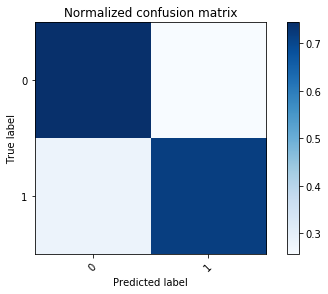

In [52]:
# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

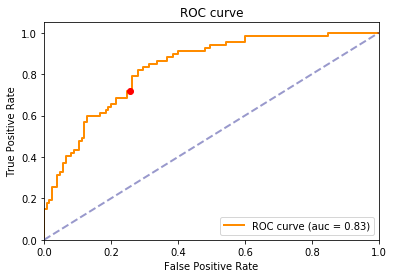

In [56]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test), probability, pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), probability)

plt.figure()

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

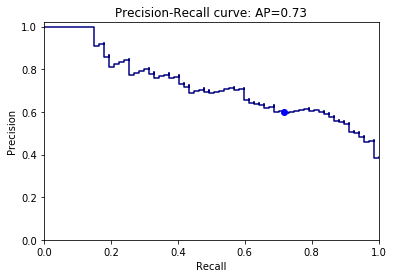

In [54]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test, probability,  pos_label=1)
ave_precision=average_precision_score(y_test, probability)

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot(cm_normalized[1,1], cm[1,1]/(cm[1,1]+cm[0,1]), 'ob')
plt.show()

In [55]:
# boto3.Session().client('sagemaker').delete_endpoint(EndpointName='xgboost-bikeRental-Optimized')